In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import joblib

from astropy.io import fits
from functools import reduce
from astropy.table import Table

sys.path.append('../../methods_code_Nresol/')
sys.path.append('../../utils/')
import astro_cuts
import importlib
import spec_utils

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
fname = 'lsd_scripts/spectrain_2_11_r50.fits'
df_allspec = spec_utils.convert_to_dataframe_specmatched(fname)
df_goodspec = spec_utils.return_goodspec(df_allspec)

/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:41: RuntimeWarning: divide by zero encountered in true_divide
  df['reduced_chisq'] = df['chisq'].to_numpy() * n_passbands / (n_passbands - 4)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:45: RuntimeWarning: divide by zero encountered in power
  sdss_flux_sig = np.power(np.array(dat['sdss_dr14_starsweep.psfflux_ivar']), -0.5)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:47: RuntimeWarning: divide by zero encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]), 0.0, np.inf)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:47: RuntimeWarning: invalid value encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]),

Number of objects before / after 596315 210713
c1 = 0.873, c2 = 0.995, c3 = 0.445
Fraction left = 0.353


In [4]:
len(df_goodspec)

210713

#### Cuts on WISE, PanSTARRS

In [5]:
magerrcols = [c.startswith('mag_err_') for c in df_goodspec.columns]
df_goodspec.columns[magerrcols]

Index(['mag_err_g', 'mag_err_r', 'mag_err_i', 'mag_err_z', 'mag_err_y',
       'mag_err_J', 'mag_err_H', 'mag_err_K'],
      dtype='object')

In [6]:
def pan_wise_cuts(df_input):
    #riz < 0.2
    psmerrs = df_input[['mag_err_r', 'mag_err_i', 'mag_err_z']].to_numpy()     
    cut1 = np.all(psmerrs<0.2, axis=1)
    #W1<0.2
    w1merr = df_input['allwise.w1sigmpro'].to_numpy()
    cut2 = w1merr<0.2
    #w1rchi2
    cut3 = df_input['allwise.w1rchi2'].to_numpy()<2
    #detected in w1
    cut4 = df_input['allwise.w1mpro'].to_numpy()!=0
    print('C1: {:.2f} C2: {:.2f} C3: {:.2f} C4: {:.2f}'.format(np.sum(cut1)/len(cut1), np.sum(cut2)/len(cut2), np.sum(cut3)/len(cut3), np.sum(cut4)/len(cut4)))
    
    effcut = cut1 * cut2 * cut3 * cut4
    
    return effcut

In [7]:
cleanphot = pan_wise_cuts(df_goodspec)
df_wise = df_goodspec.iloc[cleanphot, :]
np.sum(cleanphot)/len(cleanphot)

C1: 1.00 C2: 0.99 C3: 0.99 C4: 0.77


0.7505659356565565

In [8]:
len(df_wise)

158154

In [9]:
importlib.reload(spec_utils)

<module 'spec_utils' from '/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py'>

In [10]:
train_x, train_y, test_x, test_y = spec_utils.return_train_test_subset(df_wise, ['r-i', 'z-W1'], balance_train=True)

NumTrain, NumTest =  45144 13543
Train Class Fraction: Q = 0.5
Test Class Fraction: Q = 0.20497674075167985


In [11]:
from sklearn.svm import SVC
model = SVC(kernel='linear') #LinearSVC(max_iter=10000)
model.fit(train_x, train_y)
model.score(train_x, train_y), model.score(test_x, test_y)

(0.9965222399432926, 0.9952004725688548)

In [28]:
'''import joblib
joblib.dump(model, 'models/svm_panstarrs_quasarsep_balanced.joblib')'''

['models/svm_panstarrs_quasarsep_balanced.joblib']

In [ ]:
model = joblib.load(nmdir+'spectra_matched/models/svm_panstarrs_quasarsep_balanced.joblib')

In [29]:
plt.rcParams.update({'font.family':'serif'})

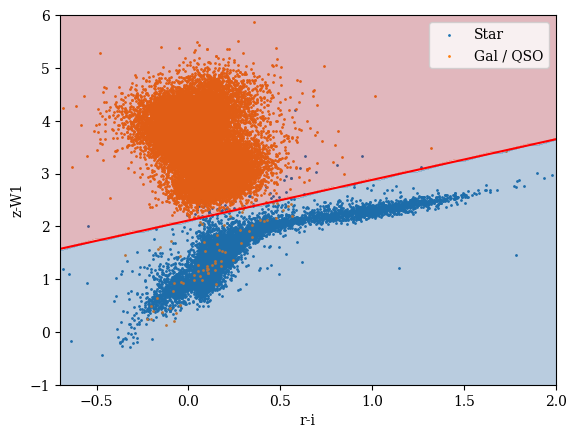

In [30]:
w = model.coef_[0]
b = model.intercept_[0]
x_points = np.linspace(np.min(train_x[:, 0]), np.max(train_x[:, 0]), num=50)
y_points = -(w[0] / w[1]) * x_points - b / w[1]
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane

h=0.05
x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict(np.vstack([xx.ravel(), yy.ravel()]).T)
Z = Z.reshape(xx.shape)

plt.figure((6, 5))
plt.scatter(train_x[train_y==1, 0], train_x[train_y==1, 1], label='Star', s=1)
plt.scatter(train_x[train_y==0, 0], train_x[train_y==0, 1], label='Gal / QSO', s=1)
plt.plot(x_points, y_points, c='r')
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)

plt.xlabel('r-i')
plt.ylabel('z-W1')
plt.xlim(-0.7, 2)
plt.ylim(-1, 6)
plt.legend()
plt.show()

### Test data plot WISE, Size: 6, 5

In [2]:
model = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')

In [14]:
train_x, train_y, test_x, test_y = spec_utils.return_train_test_subset(df_wise, ['r-i', 'z-W1'], balance_train=True)

NumTrain, NumTest =  45144 13543
Train Class Fraction: Q = 0.5
Test Class Fraction: Q = 0.20497674075167985


In [15]:
plt.rcParams.update({'font.family':'serif'})

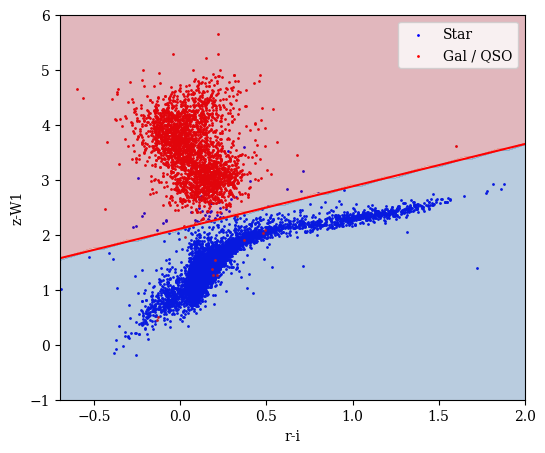

In [20]:
w = model.coef_[0]
b = model.intercept_[0]
x_points = np.linspace(np.min(train_x[:, 0]), np.max(train_x[:, 0]), num=50)
y_points = -(w[0] / w[1]) * x_points - b / w[1]
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane

h=0.05
x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict(np.vstack([xx.ravel(), yy.ravel()]).T)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.scatter(test_x[test_y==1, 0], test_x[test_y==1, 1], label='Star', s=1, c='b')
plt.scatter(test_x[test_y==0, 0], test_x[test_y==0, 1], label='Gal / QSO', s=1, c='r')
plt.plot(x_points, y_points, c='r') #hyperplane 
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)

plt.xlabel('r-i')
plt.ylabel('z-W1')
plt.xlim(-0.7, 2)
plt.ylim(-1, 6)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.savefig('../../plots/wise_7_8_test.png')
plt.show()

In [3]:
w = model.coef_[0]
b = model.intercept_[0]

In [4]:
w, b

(array([ 2.34203647, -3.04467112]), 6.425687894620658)

In [5]:
m, c =  -(w[0] / w[1]), -b / w[1]

In [6]:
m, c

(0.7692247784953247, 2.1104702768781163)